In [1]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal

In [2]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
import jax
jax.devices()

[CpuDevice(id=0)]

In [4]:
# Generate data from stable distribution
@partial(jit, static_argnames=['dataset_size','num_datasets'])
def alpha_stable(alpha, beta, gamma, delta, dataset_size, num_datasets):
    V = jnp.pi / 2 * (2 * random.uniform(key, shape = (num_datasets, dataset_size)) - 1)
    W = - jnp.log(random.uniform(key1, shape = (num_datasets, dataset_size)))

    const = beta * jnp.tan(jnp.pi * alpha / 2)
    b = jnp.arctan(const)
    s = (1 + const * const)**(1 / (2 * alpha))
    r = s * jnp.sin(alpha * V + b) / ((jnp.cos(V)) ** (1/alpha)) * (( jnp.cos( (1-alpha) * V - b ) / W )**((1-alpha)/alpha))
    r1 = gamma * r + delta

    piover2 = jnp.pi / 2
    sclshftV = piover2 + beta * V
    r_immi = 1/piover2 * (sclshftV * jnp.tan(V) - beta * jnp.log( (piover2 * W * jnp.cos(V) ) / sclshftV ))
    r2 = gamma * r_immi + (2 / jnp.pi) * beta * gamma * jnp.log(gamma) + delta
    return jnp.where(alpha !=1, r1, r2)

In [5]:
true_theta = jnp.array([1.8, 0.5, 1, 0])

In [6]:
actual_data = alpha_stable(true_theta[0], true_theta[1], true_theta[2], true_theta[3], 200, 1)
actual_data

Array([[-1.6334486 ,  1.5174317 ,  4.24649   , -4.8381543 ,  0.64197326,
         0.39844236,  2.4244406 , -1.2824332 ,  0.61709064,  0.6190466 ,
         1.3917288 ,  1.1016402 , -1.6254115 ,  0.84490776,  0.8627061 ,
        -1.8524674 ,  1.378993  , -2.183561  , -1.0380331 , -0.7735235 ,
         6.423514  ,  0.7586694 , -1.2398438 , -0.3079772 ,  0.21602353,
        -0.6321861 , -0.09919483, -1.3860799 , -1.7547234 , -1.8337234 ,
        -0.86124027,  0.9649672 ,  1.5633817 ,  2.1552198 , -1.3592112 ,
        -1.1377506 ,  1.640167  ,  2.3048286 , -2.553866  , -3.0846903 ,
         7.861281  ,  2.7072375 , -0.50437045, -1.029171  ,  2.6327825 ,
         1.4847413 , -0.71307284, -1.7468956 ,  2.2234023 ,  1.9118462 ,
        -1.9870437 , -1.1224518 ,  0.03529875,  0.36310923, -1.4472983 ,
         0.41029164,  0.9988213 , -0.09633697,  0.9191452 , -3.1026917 ,
         0.49486703,  0.785038  , -0.22163996, -3.4021223 , -1.4490677 ,
        -0.50902945,  1.3431433 , -0.8682272 ,  1.9

In [7]:
# CALCULATE SUMMARY STATS
@jit
def alpha_stable_ss(data):
  # Compute quantile statistics
  v_stability = (jnp.percentile(data, 95) - jnp.percentile(data, 5)) / (jnp.percentile(data, 75) - jnp.percentile(data, 25))
  v_skewness = (jnp.percentile(data, 95) + jnp.percentile(data, 5) - 2 * jnp.percentile(data, 50)) / (jnp.percentile(data, 95) - jnp.percentile(data, 5))
  v_scale = (jnp.percentile(data, 75) - jnp.percentile(data, 25)) / 1
  v_loc = jnp.mean(data)

  # Define interpolation matrices (see [1])
  tv_stability = jnp.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
  tv_skewness = jnp.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
  t_stability = jnp.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
  t_skewness = jnp.array([0.0, 0.25, 0.5, 0.75, 1.0])

  psi1 = jnp.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
    [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
    [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
    [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
    [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
    [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
    [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
    [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
    [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
    [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
    [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
    [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
    [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
    [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
    [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

  psi2 = jnp.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

  psi3 = jnp.array([[1.908, 1.908, 1.908, 1.908, 1.908],
    [1.914, 1.915, 1.916, 1.918, 1.921],
    [1.921, 1.922, 1.927, 1.936, 1.947],
    [1.927, 1.930, 1.943, 1.961, 1.987],
    [1.933, 1.940, 1.962, 1.997, 2.043],
    [1.939, 1.952, 1.988, 2.045, 2.116],
    [1.946, 1.967, 2.022, 2.106, 2.211],
    [1.955, 1.984, 2.067, 2.188, 2.333],
    [1.965, 2.007, 2.125, 2.294, 2.491],
    [1.980, 2.040, 2.205, 2.435, 2.696],
    [2.000, 2.085, 2.311, 2.624, 2.973],
    [2.040, 2.149, 2.461, 2.886, 3.356],
    [2.098, 2.244, 2.676, 3.265, 3.912],
    [2.189, 2.392, 3.004, 3.844, 4.775],
    [2.337, 2.635, 3.542, 4.808, 6.247],
    [2.588, 3.073, 4.534, 6.636, 9.144]])


  psi4 = jnp.array([[0.0,    0.0,    0.0,    0.0,  0.0],
    [0.0, -0.017, -0.032, -0.049, -0.064],
    [0.0, -0.030, -0.061, -0.092, -0.123],
    [0.0, -0.043, -0.088, -0.132, -0.179],
    [0.0, -0.056, -0.111, -0.170, -0.232],
    [0.0, -0.066, -0.134, -0.206, -0.283],
    [0.0, -0.075, -0.154, -0.241, -0.335],
    [0.0, -0.084, -0.173, -0.276, -0.390],
    [0.0, -0.090, -0.192, -0.310, -0.447],
    [0.0, -0.095, -0.208, -0.346, -0.508],
    [0.0, -0.098, -0.223, -0.383, -0.576],
    [0.0, -0.099, -0.237, -0.424, -0.652],
    [0.0, -0.096, -0.250, -0.469, -0.742],
    [0.0, -0.089, -0.262, -0.520, -0.853],
    [0.0, -0.078, -0.272, -0.581, -0.997],
    [0.0, -0.061, -0.279, -0.659, -1.198]])

  tv_stability_i1 = jnp.max(jnp.append(0, jnp.argwhere(tv_stability <= v_stability, size=len(tv_stability), fill_value=0)))
  tv_stability_i2 = jnp.min(jnp.append(14, jnp.argwhere(tv_stability >= v_stability, size=len(tv_stability), fill_value=14)))
  tv_skewness_i1 = jnp.max(jnp.append(0, jnp.argwhere(tv_skewness <= jnp.abs(v_skewness), size=len(tv_skewness), fill_value=0)))
  tv_skewness_i2 = jnp.min(jnp.append(6, jnp.argwhere(tv_skewness >= jnp.abs(v_skewness), size=len(tv_skewness), fill_value=6)))

  dist_stability_tv = tv_stability[tv_stability_i2] - tv_stability[tv_stability_i1]

  dist_stability = jnp.where(dist_stability_tv != 0, (v_stability - tv_stability[tv_stability_i1]) / dist_stability_tv, dist_stability_tv)

  dist_skewness_tv = tv_skewness[tv_skewness_i2] - tv_skewness[tv_skewness_i1]

  dist_skewness = jnp.where(dist_skewness_tv != 0, (jnp.abs(v_skewness) - tv_skewness[tv_skewness_i1]) / dist_skewness_tv, dist_skewness_tv)

  psi1b1 = dist_stability*psi1[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i1]
  psi1b2 = dist_stability*psi1[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i2]
  alpha = dist_skewness*psi1b2+(1-dist_skewness)*psi1b1
  psi2b1 = dist_stability*psi2[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i1]
  psi2b2 = dist_stability*psi2[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i2]
  beta = jnp.sign(v_skewness)*(dist_skewness*psi2b2+(1-dist_skewness)*psi2b1)
  t_stability_i1 = jnp.max(jnp.append(0, jnp.argwhere(t_stability >= alpha, size=len(t_stability), fill_value=0)))
  t_stability_i2 = jnp.min(jnp.append(15, jnp.argwhere(t_stability <= alpha, size=len(t_stability), fill_value=15)))
  t_skewness_i1 = jnp.max(jnp.append(0, jnp.argwhere(t_skewness <= jnp.abs(beta),size=len(t_skewness), fill_value=0)))
  t_skewness_i2 = jnp.min(jnp.append(4, jnp.argwhere(t_skewness >= jnp.abs(beta),size=len(t_skewness), fill_value=4)))

  dist_stability_t = t_stability[t_stability_i2] - t_stability[t_stability_i1]

  dist_stability = jnp.where(dist_stability_t != 0, (alpha - t_stability[t_stability_i1]) / dist_stability_t, dist_stability_t)

  dist_skewness_t = t_skewness[t_skewness_i2] - t_skewness[t_skewness_i1]

  dist_skewness = jnp.where(dist_skewness_t != 0, (jnp.abs(beta) - t_skewness[t_skewness_i1]) / dist_skewness_t, dist_skewness_t)

  psi3b1 = dist_stability*psi3[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i1]
  psi3b2 = dist_stability*psi3[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i2]
  sigma = v_scale/(dist_skewness*psi3b2+(1-dist_skewness)*psi3b1)
  psi4b1 = dist_stability*psi4[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i1]
  psi4b2 = dist_stability*psi4[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i2]
  zeta = jnp.sign(beta)*sigma*(dist_skewness*psi4b2+(1-dist_skewness)*psi4b1) + jnp.percentile(data, 50)

  mu = jnp.where(jnp.abs(alpha-1) < 0.05, zeta, zeta - beta * sigma * jnp.tan(0.5 * jnp.pi *alpha))

  return jnp.array([alpha, beta, sigma, mu]) #stability, skewness, scale, loc

In [8]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

Array([ 2.        , -0.69597113,  1.103275  ,  0.20693697], dtype=float32)

In [9]:
num_coeffs = np.shape(actual_summary_statistics)[0]
n_samples = 200
num_datasets = 200
lambda_dim = num_coeffs + int((num_coeffs * (num_coeffs + 1)) / 2)

In [10]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = alpha_stable(theta[0], theta[1], theta[2], theta[3], n_samples, n_datasets)
    n_summary_statistics = jnp.array([alpha_stable_ss(datasets[i,:]) for i in range(n_datasets)])
    sample_mean = jnp.mean(n_summary_statistics, axis = 0)
    sample_variance = jnp.cov(n_summary_statistics.T)
    return sample_mean, sample_variance

In [11]:
def my_inv(x):
    return jnp.linalg.inv(x + (jnp.eye(x.shape[0]) * 1e-7))

In [12]:
@jit
def prior(theta):
    log_prior = multivariate_normal.logpdf(theta, mean = jnp.array([0] * num_coeffs), cov= 10 * jnp.identity(num_coeffs))
    return log_prior

In [13]:
def unbiased_log_likelihood(theta, n_samples, num_datasets):
    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)
    # diff_mean_s = actual_summary_statistics - sample_mean
    # part1 = diff_mean_s.T @ my_inv(sample_variance) @ diff_mean_s
    # u_est_log_likelihood = -1/2 * jnp.linalg.slogdet(sample_variance)[1] -1/2 * part1
    return u_est_log_likelihood

In [14]:
@jit
def fun_log_q(theta, mu, l):
    log_q = multivariate_normal.logpdf(theta, mean = mu, cov= my_inv(l @ l.T))
    return log_q

In [15]:
@partial(jit, static_argnames=['num_coeffs'])
def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar
    diag_inv_l = jnp.zeros_like(l, shape=(num_coeffs,num_coeffs)).at[jnp.diag_indices_from(l)].set(jnp.diag(l))
    gradient_log_q_l = (diag_inv_l - jnp.reshape(theta - mu, (num_coeffs,1)) @ jnp.reshape(theta - mu, (1,num_coeffs)) @ l).T[jnp.triu_indices(num_coeffs)] #use * because matmul gives scalar
    return gradient_log_q_mu, gradient_log_q_l

In [16]:
@jit
def control_variates(Flat_grad_log_q, Flat_grad_lb):
    c = []
    stacked_gradient_lb = jnp.stack(Flat_grad_lb)
    stacked_gradient_log_q = jnp.stack(Flat_grad_log_q)
    for i in range(lambda_dim):
        sample_cov = jnp.cov(stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i])
        c_i = sample_cov[0, 1] / sample_cov[1, 1]
        c.append(c_i)
    c_mu = jnp.array(c[0:num_coeffs])
    c_vech_l = jnp.array(c[num_coeffs:])
    return c_mu, c_vech_l

In [17]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_tilde_q, mu_q, l_q, c_mu, c_l):
        # Calculate theta from mu, l (lambda)
        alpha_q = (2 * jnp.exp(theta_tilde_q[0]) + 1.1) / (1 + jnp.exp(theta_tilde_q[0]))
        beta_q = (jnp.exp(theta_tilde_q[1]) - 1) / (jnp.exp(theta_tilde_q[1]) + 1)
        gamma_q = jnp.exp(theta_tilde_q[2])
        delta_q = theta_tilde_q[3]
        theta_q = jnp.array([alpha_q, beta_q, gamma_q, delta_q])

        # Find gradient of LB
        llh = unbiased_log_likelihood(theta_q, n_samples, num_datasets)
        h_lambda = prior(theta_tilde_q) + llh - fun_log_q(theta_tilde_q, mu_q, l_q)

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_tilde_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([jnp.log((1.8-1.1)/(2-1.8)),jnp.log((0.5+1)/(1-0.5)),jnp.log(1),0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = my_inv(Sigma_0_inv)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  my_inv(Sigma_q_inv)
                l_q_inv =  my_inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [18]:
# Set hyperparameters
stop = 4000

In [19]:
vb = GVB(200, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

  0%|          | 1/4000 [00:05<5:47:04,  5.21s/it]

LB -15.76251


  0%|          | 2/4000 [00:06<3:29:10,  3.14s/it]

LB -15.891048


  0%|          | 3/4000 [00:08<2:35:22,  2.33s/it]

LB -15.843552


  0%|          | 4/4000 [00:09<2:09:32,  1.95s/it]

LB -15.85568


  0%|          | 5/4000 [00:10<1:54:55,  1.73s/it]

LB -15.578082


  0%|          | 6/4000 [00:12<1:50:21,  1.66s/it]

LB -15.401313


  0%|          | 7/4000 [00:13<1:42:59,  1.55s/it]

LB -15.184826


  0%|          | 8/4000 [00:15<1:37:40,  1.47s/it]

LB -15.307837


  0%|          | 9/4000 [00:16<1:34:31,  1.42s/it]

LB -15.099005


  0%|          | 10/4000 [00:17<1:32:48,  1.40s/it]

LB -15.138023


  0%|          | 11/4000 [00:19<1:32:02,  1.38s/it]

LB -14.790874


  0%|          | 12/4000 [00:20<1:31:19,  1.37s/it]

LB -15.06353


  0%|          | 13/4000 [00:21<1:33:23,  1.41s/it]

LB -14.891155


  0%|          | 14/4000 [00:23<1:36:06,  1.45s/it]

LB -14.683381


  0%|          | 15/4000 [00:24<1:36:01,  1.45s/it]

LB -14.705745


  0%|          | 16/4000 [00:26<1:33:14,  1.40s/it]

LB -15.024625


  0%|          | 17/4000 [00:27<1:32:05,  1.39s/it]

LB -14.633761


  0%|          | 18/4000 [00:28<1:31:03,  1.37s/it]

LB -14.570659


  0%|          | 19/4000 [00:30<1:35:50,  1.44s/it]

LB -14.329238


  0%|          | 20/4000 [00:32<1:36:55,  1.46s/it]

LB -14.680481


  1%|          | 21/4000 [00:33<1:37:33,  1.47s/it]

LB -14.415379


  1%|          | 22/4000 [00:35<1:43:09,  1.56s/it]

LB -14.750804


  1%|          | 23/4000 [00:37<1:47:16,  1.62s/it]

LB -14.569432


  1%|          | 24/4000 [00:38<1:50:32,  1.67s/it]

LB -14.378649


  1%|          | 25/4000 [00:40<1:50:16,  1.66s/it]

LB -14.607139


  1%|          | 26/4000 [00:41<1:43:36,  1.56s/it]

LB -14.395231


  1%|          | 27/4000 [00:43<1:37:32,  1.47s/it]

LB -14.470551


  1%|          | 28/4000 [00:44<1:35:30,  1.44s/it]

LB -14.527678


  1%|          | 29/4000 [00:45<1:31:47,  1.39s/it]

LB -14.283073


  1%|          | 30/4000 [00:47<1:30:32,  1.37s/it]

LB -14.402978


  1%|          | 31/4000 [00:48<1:29:17,  1.35s/it]

LB -14.192271


  1%|          | 32/4000 [00:49<1:30:49,  1.37s/it]

LB -14.332722


  1%|          | 33/4000 [00:51<1:32:53,  1.40s/it]

LB -14.091235


  1%|          | 34/4000 [00:52<1:31:32,  1.38s/it]

LB -14.091802


  1%|          | 35/4000 [00:54<1:33:18,  1.41s/it]

LB -14.197006


  1%|          | 36/4000 [00:55<1:35:52,  1.45s/it]

LB -13.987009


  1%|          | 37/4000 [00:57<1:34:58,  1.44s/it]

LB -14.129509


  1%|          | 38/4000 [00:58<1:36:27,  1.46s/it]

LB -13.914723


  1%|          | 39/4000 [00:59<1:33:33,  1.42s/it]

LB -13.982859


  1%|          | 40/4000 [01:01<1:34:56,  1.44s/it]

LB -13.71973


  1%|          | 41/4000 [01:02<1:33:48,  1.42s/it]

LB -13.651411


  1%|          | 42/4000 [01:04<1:32:40,  1.40s/it]

LB -13.759687


  1%|          | 43/4000 [01:05<1:32:40,  1.41s/it]

LB -14.024321


  1%|          | 44/4000 [01:07<1:34:59,  1.44s/it]

LB -13.795345


  1%|          | 45/4000 [01:08<1:45:13,  1.60s/it]

LB -13.768522


  1%|          | 46/4000 [01:10<1:44:18,  1.58s/it]

LB -13.851137


  1%|          | 47/4000 [01:12<1:48:05,  1.64s/it]

LB -13.974741


  1%|          | 48/4000 [01:13<1:41:50,  1.55s/it]

LB -13.71247


  1%|          | 49/4000 [01:14<1:37:53,  1.49s/it]

LB -13.550644


  1%|▏         | 50/4000 [01:16<1:34:08,  1.43s/it]

LB -13.919656


  1%|▏         | 51/4000 [01:17<1:32:33,  1.41s/it]

LB Smoothed -14.492256


  1%|▏         | 52/4000 [01:19<1:34:49,  1.44s/it]

LB Smoothed -14.444602


  1%|▏         | 53/4000 [01:20<1:35:29,  1.45s/it]

LB Smoothed -14.395919


  1%|▏         | 54/4000 [01:22<1:39:21,  1.51s/it]

LB Smoothed -14.35442


  1%|▏         | 55/4000 [01:23<1:35:42,  1.46s/it]

LB Smoothed -14.30503


  1%|▏         | 56/4000 [01:24<1:34:28,  1.44s/it]

LB Smoothed -14.261341


  1%|▏         | 57/4000 [01:26<1:31:02,  1.39s/it]

LB Smoothed -14.2252655


  1%|▏         | 58/4000 [01:27<1:30:44,  1.38s/it]

LB Smoothed -14.189072


  1%|▏         | 59/4000 [01:28<1:29:42,  1.37s/it]

LB Smoothed -14.154603


  2%|▏         | 60/4000 [01:30<1:27:36,  1.33s/it]

LB Smoothed -14.114474


  2%|▏         | 61/4000 [01:32<1:36:41,  1.47s/it]

LB Smoothed -14.086398


  2%|▏         | 62/4000 [01:33<1:39:08,  1.51s/it]

LB Smoothed -14.054214


  2%|▏         | 63/4000 [01:35<1:48:24,  1.65s/it]

LB Smoothed -14.0208235


  2%|▏         | 64/4000 [01:37<1:53:20,  1.73s/it]

LB Smoothed -13.990397


  2%|▏         | 65/4000 [01:39<2:00:59,  1.84s/it]

LB Smoothed -13.958889


  2%|▏         | 66/4000 [01:40<1:50:54,  1.69s/it]

LB Smoothed -13.917013


  2%|▏         | 67/4000 [01:42<1:42:05,  1.56s/it]

LB Smoothed -13.888867


  2%|▏         | 68/4000 [01:43<1:44:30,  1.59s/it]

LB Smoothed -13.858167


  2%|▏         | 69/4000 [01:45<1:46:07,  1.62s/it]

LB Smoothed -13.831024


  2%|▏         | 70/4000 [01:46<1:39:05,  1.51s/it]

LB Smoothed -13.800415


  2%|▏         | 71/4000 [01:48<1:36:29,  1.47s/it]

LB Smoothed -13.77407


  2%|▏         | 72/4000 [01:49<1:31:59,  1.41s/it]

LB Smoothed -13.736896


  2%|▏         | 73/4000 [01:50<1:29:22,  1.37s/it]

LB Smoothed -13.705795


  2%|▏         | 74/4000 [01:51<1:26:55,  1.33s/it]

LB Smoothed -13.679181


  2%|▏         | 75/4000 [01:53<1:26:49,  1.33s/it]

LB Smoothed -13.646929


  2%|▏         | 76/4000 [01:54<1:27:49,  1.34s/it]

LB Smoothed -13.619647


  2%|▏         | 77/4000 [01:56<1:28:35,  1.35s/it]

LB Smoothed -13.586214


  2%|▏         | 78/4000 [01:57<1:29:44,  1.37s/it]

LB Smoothed -13.558665


  2%|▏         | 79/4000 [01:59<1:34:46,  1.45s/it]

LB Smoothed -13.534316


  2%|▏         | 80/4000 [02:00<1:42:24,  1.57s/it]

LB Smoothed -13.499225


  2%|▏         | 81/4000 [02:02<1:40:11,  1.53s/it]

LB Smoothed -13.47636


  2%|▏         | 82/4000 [02:04<1:43:19,  1.58s/it]

LB Smoothed -13.446429


  2%|▏         | 83/4000 [02:05<1:44:45,  1.60s/it]

LB Smoothed -13.425346


  2%|▏         | 84/4000 [02:07<1:39:48,  1.53s/it]

LB Smoothed -13.395872


  2%|▏         | 85/4000 [02:08<1:46:13,  1.63s/it]

LB Smoothed -13.367197


  2%|▏         | 86/4000 [02:10<1:46:03,  1.63s/it]

LB Smoothed -13.346842


  2%|▏         | 87/4000 [02:12<1:48:14,  1.66s/it]

LB Smoothed -13.319508


  2%|▏         | 88/4000 [02:13<1:39:54,  1.53s/it]

LB Smoothed -13.2983055


  2%|▏         | 89/4000 [02:14<1:34:33,  1.45s/it]

LB Smoothed -13.28481


  2%|▏         | 90/4000 [02:16<1:31:28,  1.40s/it]

LB Smoothed -13.267937


  2%|▏         | 91/4000 [02:17<1:29:01,  1.37s/it]

LB Smoothed -13.252597


  2%|▏         | 92/4000 [02:18<1:26:27,  1.33s/it]

LB Smoothed -13.234315


  2%|▏         | 93/4000 [02:19<1:25:35,  1.31s/it]

LB Smoothed -13.212407


  2%|▏         | 94/4000 [02:21<1:24:41,  1.30s/it]

LB Smoothed -13.192816


  2%|▏         | 95/4000 [02:22<1:24:24,  1.30s/it]

LB Smoothed -13.169332


  2%|▏         | 96/4000 [02:23<1:27:03,  1.34s/it]

LB Smoothed -13.143935


  2%|▏         | 97/4000 [02:25<1:31:00,  1.40s/it]

LB Smoothed -13.116542


  2%|▏         | 98/4000 [02:26<1:29:05,  1.37s/it]

LB Smoothed -13.099182


  2%|▏         | 99/4000 [02:28<1:27:12,  1.34s/it]

LB Smoothed -13.081747


  2%|▎         | 100/4000 [02:29<1:26:17,  1.33s/it]

LB Smoothed -13.056681


  3%|▎         | 101/4000 [02:30<1:25:19,  1.31s/it]

LB Smoothed -13.035191


  3%|▎         | 102/4000 [02:31<1:25:46,  1.32s/it]

LB Smoothed -13.021576


  3%|▎         | 103/4000 [02:33<1:26:05,  1.33s/it]

LB Smoothed -13.001172


  3%|▎         | 104/4000 [02:34<1:26:22,  1.33s/it]

LB Smoothed -12.9924555


  3%|▎         | 105/4000 [02:36<1:28:02,  1.36s/it]

LB Smoothed -12.981677


  3%|▎         | 106/4000 [02:37<1:28:17,  1.36s/it]

LB Smoothed -12.961857


  3%|▎         | 107/4000 [02:38<1:28:32,  1.36s/it]

LB Smoothed -12.94068


  3%|▎         | 108/4000 [02:40<1:27:42,  1.35s/it]

LB Smoothed -12.9228


  3%|▎         | 109/4000 [02:41<1:25:46,  1.32s/it]

LB Smoothed -12.913488


  3%|▎         | 110/4000 [02:42<1:24:15,  1.30s/it]

LB Smoothed -12.901111


  3%|▎         | 111/4000 [02:43<1:23:21,  1.29s/it]

LB Smoothed -12.8864565


  3%|▎         | 112/4000 [02:45<1:23:09,  1.28s/it]

LB Smoothed -12.871256


  3%|▎         | 113/4000 [02:46<1:25:20,  1.32s/it]

LB Smoothed -12.857806


  3%|▎         | 114/4000 [02:48<1:34:14,  1.46s/it]

LB Smoothed -12.847953


  3%|▎         | 115/4000 [02:49<1:34:18,  1.46s/it]

LB Smoothed -12.836664


  3%|▎         | 116/4000 [02:51<1:32:04,  1.42s/it]

LB Smoothed -12.822873


  3%|▎         | 117/4000 [02:52<1:35:27,  1.47s/it]

LB Smoothed -12.812334


  3%|▎         | 118/4000 [02:54<1:38:45,  1.53s/it]

LB Smoothed -12.804191


  3%|▎         | 119/4000 [02:55<1:40:04,  1.55s/it]

LB Smoothed -12.788132


  3%|▎         | 120/4000 [02:57<1:36:36,  1.49s/it]

LB Smoothed -12.782851


  3%|▎         | 121/4000 [02:58<1:36:56,  1.50s/it]

LB Smoothed -12.775221


  3%|▎         | 122/4000 [03:00<1:36:23,  1.49s/it]

LB Smoothed -12.763397


  3%|▎         | 123/4000 [03:01<1:34:00,  1.45s/it]

LB Smoothed -12.754705


  3%|▎         | 124/4000 [03:03<1:33:49,  1.45s/it]

LB Smoothed -12.744919


  3%|▎         | 125/4000 [03:04<1:33:30,  1.45s/it]

LB Smoothed -12.73792


  3%|▎         | 126/4000 [03:06<1:34:48,  1.47s/it]

LB Smoothed -12.73149


  3%|▎         | 127/4000 [03:07<1:32:26,  1.43s/it]

LB Smoothed -12.7196


  3%|▎         | 128/4000 [03:08<1:33:04,  1.44s/it]

LB Smoothed -12.707464


  3%|▎         | 129/4000 [03:10<1:32:02,  1.43s/it]

LB Smoothed -12.702825


  3%|▎         | 130/4000 [03:11<1:31:36,  1.42s/it]

LB Smoothed -12.693044


  3%|▎         | 131/4000 [03:13<1:32:19,  1.43s/it]

LB Smoothed -12.689209


  3%|▎         | 132/4000 [03:14<1:31:02,  1.41s/it]

LB Smoothed -12.67662


  3%|▎         | 133/4000 [03:15<1:31:09,  1.41s/it]

LB Smoothed -12.676192


  3%|▎         | 134/4000 [03:17<1:30:49,  1.41s/it]

LB Smoothed -12.674948


  3%|▎         | 135/4000 [03:18<1:30:34,  1.41s/it]

LB Smoothed -12.665477


  3%|▎         | 136/4000 [03:20<1:32:52,  1.44s/it]

LB Smoothed -12.664264


  3%|▎         | 137/4000 [03:21<1:31:40,  1.42s/it]

LB Smoothed -12.658494


  3%|▎         | 138/4000 [03:22<1:30:40,  1.41s/it]

LB Smoothed -12.644185


  3%|▎         | 139/4000 [03:24<1:30:57,  1.41s/it]

LB Smoothed -12.635178


  4%|▎         | 140/4000 [03:25<1:31:12,  1.42s/it]

LB Smoothed -12.630723


  4%|▎         | 141/4000 [03:27<1:32:11,  1.43s/it]

LB Smoothed -12.6249895


  4%|▎         | 142/4000 [03:28<1:31:19,  1.42s/it]

LB Smoothed -12.618915


  4%|▎         | 143/4000 [03:30<1:32:19,  1.44s/it]

LB Smoothed -12.606283


  4%|▎         | 144/4000 [03:31<1:31:17,  1.42s/it]

LB Smoothed -12.604046


  4%|▎         | 145/4000 [03:32<1:31:04,  1.42s/it]

LB Smoothed -12.599039


  4%|▎         | 146/4000 [03:34<1:31:05,  1.42s/it]

LB Smoothed -12.59301


  4%|▎         | 147/4000 [03:35<1:33:24,  1.45s/it]

LB Smoothed -12.581504


  4%|▎         | 148/4000 [03:37<1:31:45,  1.43s/it]

LB Smoothed -12.5770235


  4%|▎         | 149/4000 [03:38<1:32:16,  1.44s/it]

LB Smoothed -12.569309


  4%|▍         | 150/4000 [03:40<1:34:06,  1.47s/it]

LB Smoothed -12.56823


  4%|▍         | 151/4000 [03:42<1:39:38,  1.55s/it]

LB Smoothed -12.569104


  4%|▍         | 152/4000 [03:43<1:40:00,  1.56s/it]

LB Smoothed -12.5616255


  4%|▍         | 153/4000 [03:45<1:40:07,  1.56s/it]

LB Smoothed -12.549817


  4%|▍         | 154/4000 [03:46<1:38:35,  1.54s/it]

LB Smoothed -12.544405


  4%|▍         | 155/4000 [03:48<1:36:21,  1.50s/it]

LB Smoothed -12.540553


  4%|▍         | 156/4000 [03:49<1:36:13,  1.50s/it]

LB Smoothed -12.543217


  4%|▍         | 157/4000 [03:51<1:41:49,  1.59s/it]

LB Smoothed -12.541676


  4%|▍         | 158/4000 [03:53<1:53:56,  1.78s/it]

LB Smoothed -12.538594


  4%|▍         | 159/4000 [03:55<1:49:47,  1.72s/it]

LB Smoothed -12.534182


  4%|▍         | 160/4000 [03:56<1:49:38,  1.71s/it]

LB Smoothed -12.525314


  4%|▍         | 161/4000 [03:58<1:41:45,  1.59s/it]

LB Smoothed -12.518756


  4%|▍         | 162/4000 [03:59<1:38:00,  1.53s/it]

LB Smoothed -12.514907


  4%|▍         | 163/4000 [04:00<1:34:06,  1.47s/it]

LB Smoothed -12.507745


  4%|▍         | 164/4000 [04:02<1:30:22,  1.41s/it]

LB Smoothed -12.507869


  4%|▍         | 165/4000 [04:03<1:29:05,  1.39s/it]

LB Smoothed -12.5044365


  4%|▍         | 166/4000 [04:04<1:28:55,  1.39s/it]

LB Smoothed -12.494801


  4%|▍         | 167/4000 [04:06<1:28:11,  1.38s/it]

LB Smoothed -12.488615


  4%|▍         | 168/4000 [04:07<1:29:24,  1.40s/it]

LB Smoothed -12.485496


  4%|▍         | 169/4000 [04:09<1:33:00,  1.46s/it]

LB Smoothed -12.471584


  4%|▍         | 170/4000 [04:10<1:33:03,  1.46s/it]

LB Smoothed -12.467054


  4%|▍         | 171/4000 [04:12<1:35:07,  1.49s/it]

LB Smoothed -12.460229


  4%|▍         | 172/4000 [04:14<1:39:01,  1.55s/it]

LB Smoothed -12.4579525


  4%|▍         | 173/4000 [04:15<1:40:10,  1.57s/it]

LB Smoothed -12.456394


  4%|▍         | 174/4000 [04:17<1:41:36,  1.59s/it]

LB Smoothed -12.448619


  4%|▍         | 175/4000 [04:18<1:41:52,  1.60s/it]

LB Smoothed -12.444973


  4%|▍         | 176/4000 [04:20<1:47:48,  1.69s/it]

LB Smoothed -12.443007


  4%|▍         | 177/4000 [04:22<1:51:41,  1.75s/it]

LB Smoothed -12.439519


  4%|▍         | 178/4000 [04:24<1:51:12,  1.75s/it]

LB Smoothed -12.4405985


  4%|▍         | 179/4000 [04:25<1:44:46,  1.65s/it]

LB Smoothed -12.437906


  4%|▍         | 180/4000 [04:27<1:43:37,  1.63s/it]

LB Smoothed -12.428399


  5%|▍         | 181/4000 [04:28<1:39:56,  1.57s/it]

LB Smoothed -12.421513


  5%|▍         | 182/4000 [04:30<1:40:10,  1.57s/it]

LB Smoothed -12.414336


  5%|▍         | 183/4000 [04:32<1:44:53,  1.65s/it]

LB Smoothed -12.405746


  5%|▍         | 184/4000 [04:33<1:46:17,  1.67s/it]

LB Smoothed -12.404606


  5%|▍         | 185/4000 [04:35<1:44:27,  1.64s/it]

LB Smoothed -12.398759


  5%|▍         | 186/4000 [04:37<1:43:32,  1.63s/it]

LB Smoothed -12.399403


  5%|▍         | 187/4000 [04:39<1:47:42,  1.69s/it]

LB Smoothed -12.391733


  5%|▍         | 188/4000 [04:40<1:52:03,  1.76s/it]

LB Smoothed -12.3884325


  5%|▍         | 189/4000 [04:43<2:01:15,  1.91s/it]

LB Smoothed -12.382057


  5%|▍         | 190/4000 [04:44<1:55:46,  1.82s/it]

LB Smoothed -12.372135


  5%|▍         | 191/4000 [04:46<1:47:50,  1.70s/it]

LB Smoothed -12.359696


  5%|▍         | 192/4000 [04:47<1:41:08,  1.59s/it]

LB Smoothed -12.364112


  5%|▍         | 193/4000 [04:49<1:38:11,  1.55s/it]

LB Smoothed -12.357501


  5%|▍         | 194/4000 [04:50<1:39:59,  1.58s/it]

LB Smoothed -12.351287


  5%|▍         | 195/4000 [04:52<1:45:13,  1.66s/it]

LB Smoothed -12.34873


  5%|▍         | 196/4000 [04:54<1:54:57,  1.81s/it]

LB Smoothed -12.346969


  5%|▍         | 197/4000 [04:56<1:57:59,  1.86s/it]

LB Smoothed -12.341386


  5%|▍         | 198/4000 [04:58<1:54:04,  1.80s/it]

LB Smoothed -12.345833


  5%|▍         | 199/4000 [04:59<1:51:38,  1.76s/it]

LB Smoothed -12.337676


  5%|▌         | 200/4000 [05:01<1:50:07,  1.74s/it]

LB Smoothed -12.326819


  5%|▌         | 201/4000 [05:03<1:43:42,  1.64s/it]

LB Smoothed -12.317009


  5%|▌         | 202/4000 [05:04<1:45:00,  1.66s/it]

LB Smoothed -12.319267


  5%|▌         | 203/4000 [05:06<1:45:23,  1.67s/it]

LB Smoothed -12.312746


  5%|▌         | 204/4000 [05:08<1:45:21,  1.67s/it]

LB Smoothed -12.310984


  5%|▌         | 205/4000 [05:09<1:44:06,  1.65s/it]

LB Smoothed -12.302235


  5%|▌         | 206/4000 [05:11<1:46:37,  1.69s/it]

LB Smoothed -12.297809


  5%|▌         | 207/4000 [05:13<1:51:58,  1.77s/it]

LB Smoothed -12.29041


  5%|▌         | 208/4000 [05:15<1:49:12,  1.73s/it]

LB Smoothed -12.283223


  5%|▌         | 209/4000 [05:16<1:50:07,  1.74s/it]

LB Smoothed -12.28048


  5%|▌         | 210/4000 [05:18<1:43:55,  1.65s/it]

LB Smoothed -12.280371


  5%|▌         | 211/4000 [05:19<1:36:33,  1.53s/it]

LB Smoothed -12.278831


  5%|▌         | 212/4000 [05:20<1:32:45,  1.47s/it]

LB Smoothed -12.278977


  5%|▌         | 213/4000 [05:22<1:28:02,  1.39s/it]

LB Smoothed -12.273978


  5%|▌         | 214/4000 [05:23<1:25:57,  1.36s/it]

LB Smoothed -12.267948


  5%|▌         | 215/4000 [05:24<1:28:11,  1.40s/it]

LB Smoothed -12.269422


  5%|▌         | 216/4000 [05:26<1:29:21,  1.42s/it]

LB Smoothed -12.265261


  5%|▌         | 217/4000 [05:27<1:32:56,  1.47s/it]

LB Smoothed -12.266591


  5%|▌         | 218/4000 [05:29<1:35:21,  1.51s/it]

LB Smoothed -12.268637


  5%|▌         | 219/4000 [05:31<1:43:59,  1.65s/it]

LB Smoothed -12.269907


  6%|▌         | 220/4000 [05:33<1:45:29,  1.67s/it]

LB Smoothed -12.27052


  6%|▌         | 221/4000 [05:34<1:45:03,  1.67s/it]

LB Smoothed -12.258777


  6%|▌         | 222/4000 [05:36<1:45:04,  1.67s/it]

LB Smoothed -12.251412


  6%|▌         | 223/4000 [05:38<1:52:32,  1.79s/it]

LB Smoothed -12.253172


  6%|▌         | 224/4000 [05:40<1:50:32,  1.76s/it]

LB Smoothed -12.251399


  6%|▌         | 225/4000 [05:41<1:46:18,  1.69s/it]

LB Smoothed -12.241874


  6%|▌         | 226/4000 [05:43<1:39:10,  1.58s/it]

LB Smoothed -12.240706


  6%|▌         | 227/4000 [05:44<1:37:02,  1.54s/it]

LB Smoothed -12.234677


  6%|▌         | 228/4000 [05:46<1:34:12,  1.50s/it]

LB Smoothed -12.225389


  6%|▌         | 229/4000 [05:47<1:33:21,  1.49s/it]

LB Smoothed -12.219317


  6%|▌         | 230/4000 [05:49<1:34:01,  1.50s/it]

LB Smoothed -12.223554


  6%|▌         | 231/4000 [05:50<1:35:59,  1.53s/it]

LB Smoothed -12.2211685


  6%|▌         | 232/4000 [05:52<1:38:02,  1.56s/it]

LB Smoothed -12.221271


  6%|▌         | 233/4000 [05:54<1:43:37,  1.65s/it]

LB Smoothed -12.213849


  6%|▌         | 234/4000 [05:55<1:44:35,  1.67s/it]

LB Smoothed -12.210613


  6%|▌         | 235/4000 [05:57<1:47:45,  1.72s/it]

LB Smoothed -12.206569


  6%|▌         | 236/4000 [05:58<1:39:58,  1.59s/it]

LB Smoothed -12.209243


  6%|▌         | 237/4000 [06:00<1:40:10,  1.60s/it]

LB Smoothed -12.209063


  6%|▌         | 238/4000 [06:02<1:40:40,  1.61s/it]

LB Smoothed -12.204669


  6%|▌         | 239/4000 [06:03<1:41:08,  1.61s/it]

LB Smoothed -12.211493


  6%|▌         | 240/4000 [06:05<1:39:48,  1.59s/it]

LB Smoothed -12.221043


  6%|▌         | 241/4000 [06:06<1:35:50,  1.53s/it]

LB Smoothed -12.211565


  6%|▌         | 242/4000 [06:08<1:31:56,  1.47s/it]

LB Smoothed -12.211484


  6%|▌         | 243/4000 [06:09<1:28:50,  1.42s/it]

LB Smoothed -12.213509


  6%|▌         | 244/4000 [06:10<1:27:06,  1.39s/it]

LB Smoothed -12.211809


  6%|▌         | 245/4000 [06:12<1:26:20,  1.38s/it]

LB Smoothed -12.213898


  6%|▌         | 246/4000 [06:13<1:27:27,  1.40s/it]

LB Smoothed -12.209088


  6%|▌         | 247/4000 [06:14<1:29:32,  1.43s/it]

LB Smoothed -12.203192


  6%|▌         | 248/4000 [06:16<1:31:52,  1.47s/it]

LB Smoothed -12.20429


  6%|▌         | 249/4000 [06:18<1:34:35,  1.51s/it]

LB Smoothed -12.203802


  6%|▋         | 250/4000 [06:20<1:47:02,  1.71s/it]

LB Smoothed -12.206266


  6%|▋         | 251/4000 [06:21<1:41:36,  1.63s/it]

LB Smoothed -12.2035475


  6%|▋         | 252/4000 [06:23<1:40:07,  1.60s/it]

LB Smoothed -12.204953


  6%|▋         | 253/4000 [06:24<1:34:47,  1.52s/it]

LB Smoothed -12.203186


  6%|▋         | 254/4000 [06:25<1:31:19,  1.46s/it]

LB Smoothed -12.203342


  6%|▋         | 255/4000 [06:27<1:29:28,  1.43s/it]

LB Smoothed -12.204669


  6%|▋         | 256/4000 [06:28<1:29:44,  1.44s/it]

LB Smoothed -12.206866


  6%|▋         | 257/4000 [06:30<1:27:31,  1.40s/it]

LB Smoothed -12.202339


  6%|▋         | 258/4000 [06:31<1:29:02,  1.43s/it]

LB Smoothed -12.204542


  6%|▋         | 259/4000 [06:33<1:32:01,  1.48s/it]

LB Smoothed -12.208862


  6%|▋         | 260/4000 [06:34<1:34:05,  1.51s/it]

LB Smoothed -12.208593


  7%|▋         | 261/4000 [06:36<1:38:34,  1.58s/it]

LB Smoothed -12.2046795


  7%|▋         | 262/4000 [06:38<1:41:52,  1.64s/it]

LB Smoothed -12.2122


  7%|▋         | 263/4000 [06:39<1:38:07,  1.58s/it]

LB Smoothed -12.216769


  7%|▋         | 264/4000 [06:41<1:34:33,  1.52s/it]

LB Smoothed -12.214657


  7%|▋         | 265/4000 [06:42<1:30:52,  1.46s/it]

LB Smoothed -12.218304


  7%|▋         | 266/4000 [06:44<1:33:47,  1.51s/it]

LB Smoothed -12.218474


  7%|▋         | 267/4000 [06:45<1:29:37,  1.44s/it]

LB Smoothed -12.217172


  7%|▋         | 268/4000 [06:46<1:29:47,  1.44s/it]

LB Smoothed -12.212439


  7%|▋         | 269/4000 [06:48<1:27:46,  1.41s/it]

LB Smoothed -12.209522


  7%|▋         | 270/4000 [06:49<1:27:21,  1.41s/it]

LB Smoothed -12.2153425


  7%|▋         | 271/4000 [06:50<1:25:39,  1.38s/it]

LB Smoothed -12.218137


  7%|▋         | 272/4000 [06:52<1:25:19,  1.37s/it]

LB Smoothed -12.214133


  7%|▋         | 273/4000 [06:53<1:26:52,  1.40s/it]

LB Smoothed -12.210889


  7%|▋         | 274/4000 [06:55<1:29:26,  1.44s/it]

LB Smoothed -12.210837


  7%|▋         | 275/4000 [06:56<1:28:37,  1.43s/it]

LB Smoothed -12.208042


  7%|▋         | 276/4000 [06:58<1:29:39,  1.44s/it]

LB Smoothed -12.207881


  7%|▋         | 277/4000 [06:59<1:27:05,  1.40s/it]

LB Smoothed -12.212011


  7%|▋         | 278/4000 [07:00<1:27:35,  1.41s/it]

LB Smoothed -12.217055


  7%|▋         | 279/4000 [07:02<1:26:14,  1.39s/it]

LB Smoothed -12.210297


  7%|▋         | 280/4000 [07:03<1:25:38,  1.38s/it]

LB Smoothed -12.216251


  7%|▋         | 281/4000 [07:04<1:24:25,  1.36s/it]

LB Smoothed -12.206201


  7%|▋         | 282/4000 [07:06<1:24:15,  1.36s/it]

LB Smoothed -12.210315


  7%|▋         | 283/4000 [07:07<1:24:08,  1.36s/it]

LB Smoothed -12.210618


  7%|▋         | 284/4000 [07:09<1:31:53,  1.48s/it]

LB Smoothed -12.213444


  7%|▋         | 285/4000 [07:10<1:30:59,  1.47s/it]

LB Smoothed -12.208353


  7%|▋         | 286/4000 [07:12<1:29:22,  1.44s/it]

LB Smoothed -12.207537


  7%|▋         | 287/4000 [07:13<1:30:47,  1.47s/it]

LB Smoothed -12.209881


  7%|▋         | 288/4000 [07:14<1:27:30,  1.41s/it]

LB Smoothed -12.2116


  7%|▋         | 289/4000 [07:16<1:24:47,  1.37s/it]

LB Smoothed -12.207544


  7%|▋         | 290/4000 [07:17<1:22:44,  1.34s/it]

LB Smoothed -12.208212


  7%|▋         | 291/4000 [07:18<1:22:58,  1.34s/it]

LB Smoothed -12.211454


  7%|▋         | 292/4000 [07:20<1:23:13,  1.35s/it]

LB Smoothed -12.209435


  7%|▋         | 293/4000 [07:21<1:23:47,  1.36s/it]

LB Smoothed -12.216343


  7%|▋         | 294/4000 [07:22<1:23:54,  1.36s/it]

LB Smoothed -12.218417


  7%|▋         | 295/4000 [07:24<1:23:16,  1.35s/it]

LB Smoothed -12.224956


  7%|▋         | 296/4000 [07:25<1:22:54,  1.34s/it]

LB Smoothed -12.228941


  7%|▋         | 297/4000 [07:27<1:27:11,  1.41s/it]

LB Smoothed -12.239023


  7%|▋         | 298/4000 [07:28<1:24:40,  1.37s/it]

LB Smoothed -12.235127


  7%|▋         | 299/4000 [07:29<1:25:14,  1.38s/it]

LB Smoothed -12.236597


  8%|▊         | 300/4000 [07:31<1:25:33,  1.39s/it]

LB Smoothed -12.242307


  8%|▊         | 301/4000 [07:32<1:23:29,  1.35s/it]

LB Smoothed -12.242434


  8%|▊         | 302/4000 [07:33<1:25:34,  1.39s/it]

LB Smoothed -12.245122


  8%|▊         | 303/4000 [07:35<1:27:05,  1.41s/it]

LB Smoothed -12.248679


  8%|▊         | 304/4000 [07:36<1:29:34,  1.45s/it]

LB Smoothed -12.245218


  8%|▊         | 305/4000 [07:38<1:32:59,  1.51s/it]

LB Smoothed -12.2423115


  8%|▊         | 306/4000 [07:40<1:42:02,  1.66s/it]

LB Smoothed -12.246189


  8%|▊         | 307/4000 [07:42<1:45:55,  1.72s/it]

LB Smoothed -12.248415


  8%|▊         | 307/4000 [07:44<1:33:05,  1.51s/it]

LB Smoothed -12.243177
Stop at 307


<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

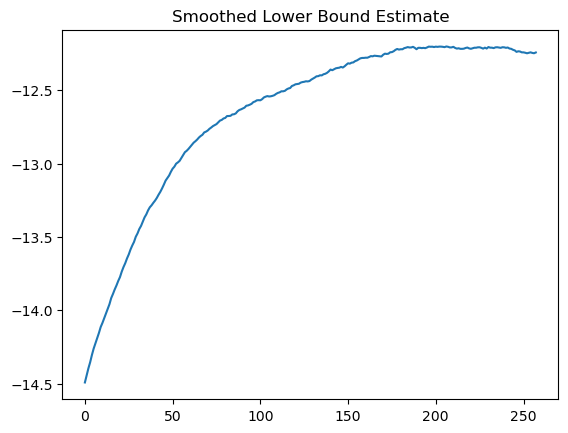

In [21]:
import pandas as pd
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [22]:
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_tilde = random.multivariate_normal(subkeys[3], mean = best_mu, cov = best_Sigma, shape = (1000,))
best_alpha = (2 * jnp.exp(best_theta_tilde[:,0]) + 1.1) / (1 + jnp.exp(best_theta_tilde[:,0]))
best_beta = (jnp.exp(best_theta_tilde[:,1]) - 1) / (jnp.exp(best_theta_tilde[:,1]) + 1)
best_gamma = jnp.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = jnp.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = jnp.mean(best_theta, axis = 1)
posterior_mean_estimate

Array([1.8683103 , 0.4065483 , 1.0894978 , 0.20968421], dtype=float32)

In [ ]:
best_lambda_mu = jnp.array([ 1.5921234 ,  0.8758456 , -0.09510029,  0.19848666])
best_lambda_l = jnp.array([10.462973  , -0.20588468,  0.06805911, -0.01834287,
             10.504364  , -0.02211663,  0.09543709,  9.265755  ,
             -0.25945738, 10.087319  ])
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_tilde = random.multivariate_normal(subkeys[6], mean = best_mu, cov = best_Sigma, shape = (1000,))
best_alpha = (2 * jnp.exp(best_theta_tilde[:,0]) + 1.1) / (1 + jnp.exp(best_theta_tilde[:,0]))
best_beta = (jnp.exp(best_theta_tilde[:,1]) - 1) / (jnp.exp(best_theta_tilde[:,1]) + 1)
best_gamma = jnp.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = jnp.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate_rvbsl = jnp.mean(best_theta, axis = 1)

In [ ]:
best_lambda_mu = jnp.array([ 1.2225926 ,  1.1738504 , -0.0637335 ,  0.06715619])
best_lambda_l = jnp.array([ 1.0475696e+01, -1.7527211e-03, -1.3112575e-01,
              3.6996447e-02,  1.0206658e+01,  9.5298715e-02,
              1.0707750e-01,  9.8733253e+00, -4.3959993e-01,
              1.0134060e+01])
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_tilde = random.multivariate_normal(subkeys[4], mean = best_mu, cov = best_Sigma, shape = (1000,))
best_alpha = (2 * jnp.exp(best_theta_tilde[:,0]) + 1.1) / (1 + jnp.exp(best_theta_tilde[:,0]))
best_beta = (jnp.exp(best_theta_tilde[:,1]) - 1) / (jnp.exp(best_theta_tilde[:,1]) + 1)
best_gamma = jnp.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = jnp.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate_wg = jnp.mean(best_theta, axis = 1)

In [ ]:
best_lambda_mu = jnp.array([ 1.60884578,  1.95080609, -0.06379721,  0.05605712])
best_lambda_l = jnp.array([  1.27092882,  0.08605892, -4.24377805,  1.95884102,  0.39900768,
               0.69624605, -1.4211206 ,  9.27891274, -0.24456171,  5.41814743])
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_tilde = random.multivariate_normal(subkeys[32], mean = best_mu, cov = best_Sigma, shape = (1000,))
best_alpha = (2 * jnp.exp(best_theta_tilde[:,0]) + 1.1) / (1 + jnp.exp(best_theta_tilde[:,0]))
best_beta = (jnp.exp(best_theta_tilde[:,1]) - 1) / (jnp.exp(best_theta_tilde[:,1]) + 1)
best_gamma = jnp.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = jnp.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate_rvbsl_wg = jnp.mean(best_theta, axis = 1)

In [ ]:
from sklearn.neighbors import KernelDensity

plt.figure()
x_plot = jnp.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde.fit(best_alpha.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

In [ ]:
plt.figure()
x_plot = jnp.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.002)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(best_beta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

In [ ]:
plt.figure()
x_plot = jnp.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_gamma.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

In [ ]:
plt.figure()
x_plot = jnp.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_delta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=1.5)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')